# Figure 11 --- Two-player experiment

In [14]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import PIL
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from Config.config import PATHS
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements, Grid
from Utils.plot_utils import PlotsAndMeasures, BarRenderer

In [15]:
file_name = '2-player-UR.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['model'] = data['treatment']
data.head(2)

Loading data from /Users/edgar/Repositorios/Cognitive_Models_El_Farol_Bar_Problem/data/human/2-player-UR.csv...


,source,treatment,group,round,player,choice,score,attendance,ac_score,threshold,num_players,room,decision,model
0,human,score + grid,Grupo-0001,1,405186428721292,0,0,1,25,0.5,2,Grupo-0001,0,score + grid
1,human,score + grid,Grupo-0001,1,728608683559397,1,1,1,25,0.5,2,Grupo-0001,1,score + grid


### Playout examples

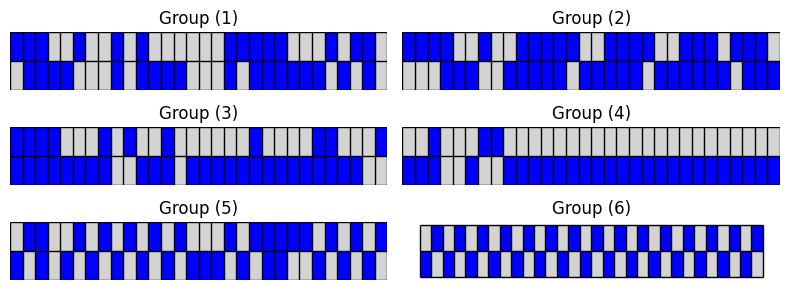

In [16]:
#-------------------------------
# Select groups
#-------------------------------
groups = [
    'Grupo-0017', 'Grupo-0022', 'Grupo-0004',
    'Grupo-0021', 'Grupo-0008', 'Grupo-0006'
]
#-------------------------------
# Plot groups
#-------------------------------
grid = Grid(len(groups))
fig, axes = plt.subplots(
    grid.rows, grid.cols, 
    figsize=(grid.cols*4, grid.rows),
    tight_layout=True
)
for i, group in enumerate(groups):
    df = data[data['room'] == group]
    bar_renderer = BarRenderer(data=df)
    bar_renderer.render(
        ax=axes[grid.index_to_pair(i)], 
        title=f"Group ({i+1})",
        num_rounds=30
    )

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
second_row_array = np.array(pil_image)

### Average score per round

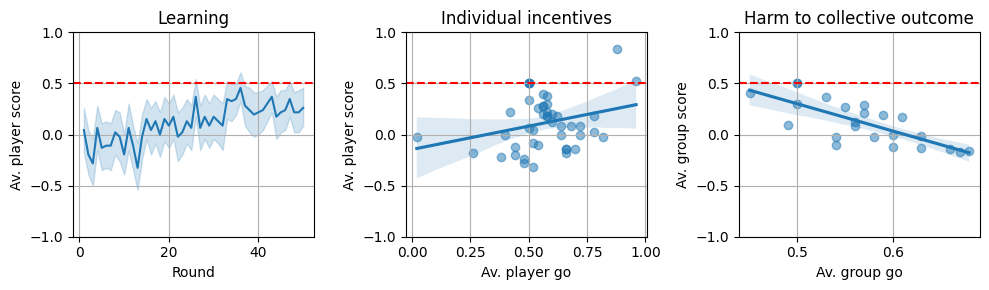

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(10,3), tight_layout=True)

# Learning: average score increases per round
sns.lineplot(
    x='round', y='score', data=data,
    ci=95, ax=ax[0]
)
ax[0].set_xlabel('Round')
ax[0].set_ylabel("Av. player score")
ax[0].set_title("Learning")
ax[0].grid()
ax[0].axhline(0.5, ls='--', color='red')
ax[0].set_ylim([-1,1])

# Individual incentives: the more the player goes, the higher the average score
av_scores = data.groupby(['player']).agg({
    'score':'mean',
    'decision':'mean'
})
sns.regplot(
    x='decision', y='score',
    scatter_kws={'alpha': 0.5}, 
    data=av_scores, ax=ax[1]
)
ax[1].set_xlabel("Av. player go")
ax[1].set_ylabel("Av. player score")
ax[1].set_title("Individual incentives")
ax[1].grid()
ax[1].axhline(0.5, ls='--', color='red')
ax[1].set_ylim([-1,1])

# Harm to collective outcome
av_scores = data.groupby(['group']).agg({
    'score':'mean',
    'decision':'mean'
})
sns.regplot(
    x='decision', y='score', 
    scatter_kws={'alpha': 0.5}, 
    data=av_scores, ax=ax[2]
)
ax[2].set_xlabel("Av. group go")
ax[2].set_ylabel("Av. group score")
ax[2].set_title("Harm to collective outcome")
ax[2].grid()
ax[2].axhline(0.5, ls='--', color='red')
ax[2].set_ylim([-1,1])

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
first_row_array = np.array(pil_image)

fig.savefig(PATHS['bar_images'] / 'learning.png', dpi=300, bbox_inches='tight')

### Distribution of relevant measures

In [ ]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'inequality']
)
df = gm.get_measurements()
alt_index = AlternationIndex.from_file(priority='sklearn')

# Get treatment for each group
dict_treatment = dict(
    zip(data['group'].tolist(), data['treatment'].tolist())
)
treatments = np.vectorize(lambda x: dict_treatment.get(x))(data['group'].unique().tolist())

df1 = pd.DataFrame({
    'group': data['group'].unique().tolist(),
    'treatment': treatments,
    'alternation index': alt_index(df)
}) 

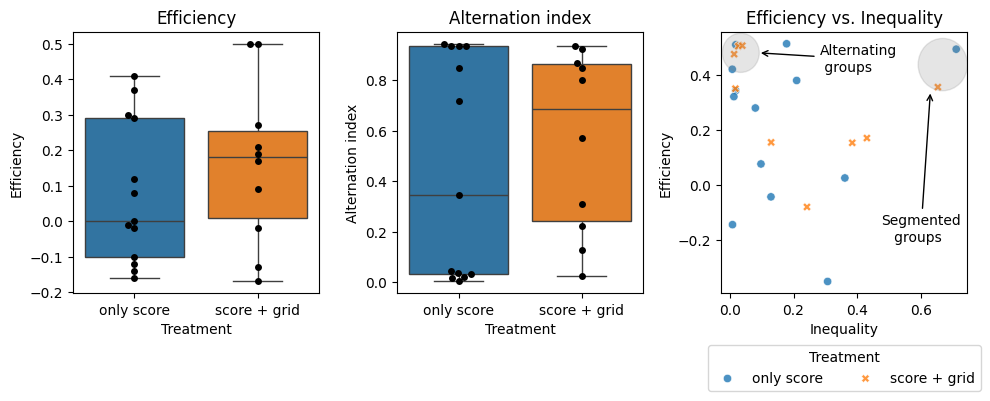

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(10,4), tight_layout=True)

# Distribution of efficiency
av_scores = data.groupby(['treatment', 'group']).agg({
    'score':'mean',
    'decision':'mean'
})
sns.boxplot(
    x='treatment', y='score', hue='treatment',
    data=av_scores, ax=ax[0], 
    order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
sns.swarmplot(
    x='treatment', y='score', color='black',
    data=av_scores, ax=ax[0], order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
ax[0].set_xlabel('Treatment')
ax[0].set_ylabel('Efficiency')
ax[0].set_title('Efficiency')

# Distribution of alternation index per treatment
sns.boxplot(
    x='treatment', y='alternation index', hue='treatment',
    data=df1, ax=ax[1], order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
sns.swarmplot(
    x='treatment', y='alternation index',
    data=df1, color='black', ax=ax[1],
    order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
ax[1].set_xlabel('Treatment')
ax[1].set_ylabel('Alternation index')
ax[1].set_title('Alternation index')

# Scatter plot efficiency vs. inequality
df_jitter = df.copy()
n = df_jitter.shape[0]
df_jitter['inequality'] = df_jitter['inequality'] + np.random.normal(0,0.0075, n)
df_jitter['efficiency'] = df_jitter['efficiency'] + np.random.normal(0,0.0075, n)
sns.scatterplot(
    x='inequality', y='efficiency',
    data=df_jitter, hue='treatment', style='treatment',
    alpha=0.8, ax=ax[2],
    hue_order=['only score', 'score + grid'],
)

# Show the alternating groups on the top-left corner
circle = patches.Circle(
    (0.08, 0.92), 0.075, 
    transform=ax[2].transAxes, 
    color='gray', alpha=0.2, 
)
ax[2].add_patch(circle)
# Add an arrow pointing to the cluster
ax[2].annotate(
    'Alternating\n groups',
    xy=(0.15, 0.92), xycoords='axes fraction',
    xytext=(0.4, 0.85), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Show the segmented groups on the top-right corner
circle = patches.Circle((0.9, 0.875), 0.1, transform=ax[2].transAxes, 
                        color='gray', alpha=0.2)
ax[2].add_patch(circle)
# Add an arrow pointing to the cluster
ax[2].annotate(
    'Segmented\n   groups',
    xy=(0.85, 0.775), xycoords='axes fraction',
    xytext=(0.65, 0.2), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)
ax[2].set_xlabel('Inequality')
ax[2].set_ylabel('Efficiency')
ax[2].set_title('Efficiency vs. Inequality')
ax[2].legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.4),
    ncol=2
)

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
third_row_array = np.array(pil_image)

In [ ]:
# Aquí los tests estadísticos

# All panels for Figure 11

(-0.5, 999.5, 399.5, -0.5)

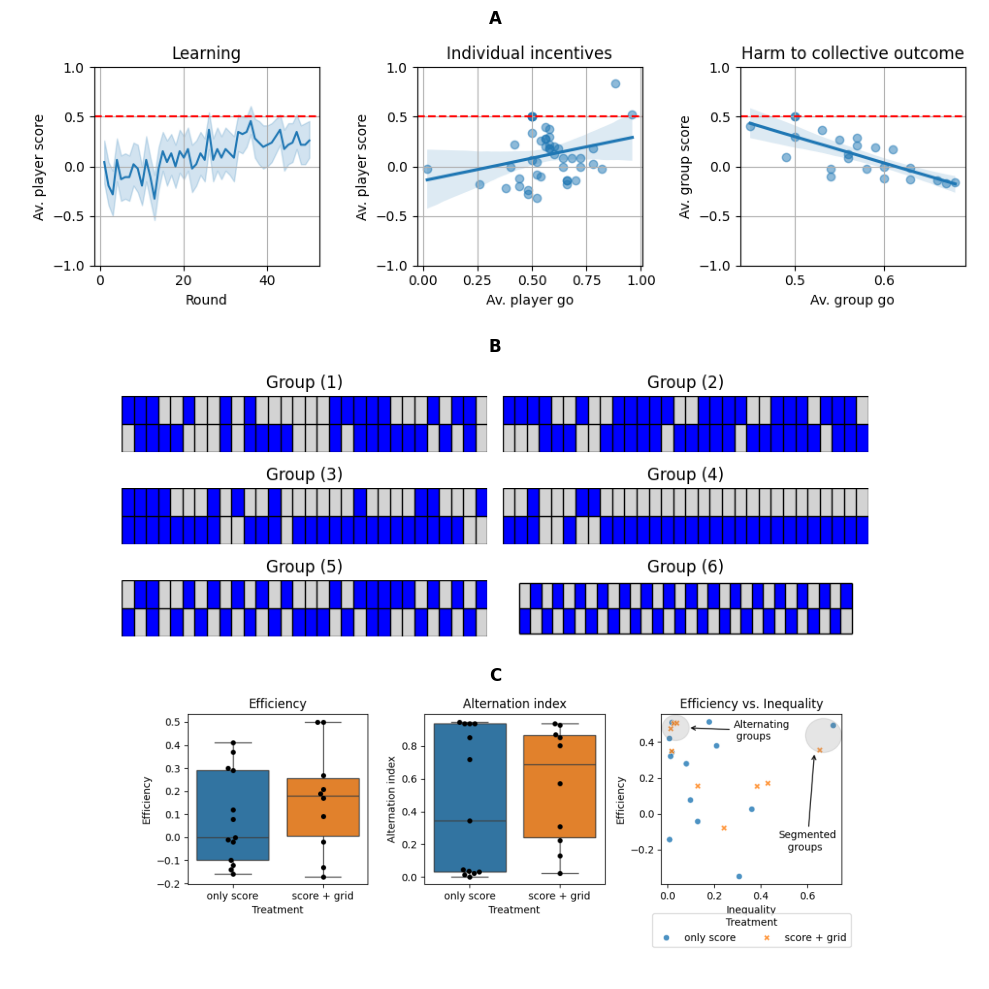

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(10,10), tight_layout=True)

ax[0].imshow(first_row_array)
ax[1].imshow(second_row_array)
ax[2].imshow(third_row_array)

ax[0].set_title('A', fontweight="bold")
ax[1].set_title('B', fontweight="bold")
ax[2].set_title('C', fontweight="bold")

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [35]:
fig.savefig('Figure11.png', dpi=300, bbox_inches='tight')

---

fig, ax = plt.subplots(1, 1, figsize=(4,4), tight_layout=True)

# Scatter plot efficiency vs. inequality
df_jitter = df.copy()
n = df_jitter.shape[0]
df_jitter['inequality'] = df_jitter['inequality'] + np.random.normal(0,0.0075, n)
df_jitter['efficiency'] = df_jitter['efficiency'] + np.random.normal(0,0.0075, n)
sns.scatterplot(
    x='inequality', y='efficiency',
    data=df_jitter, hue='treatment', style='treatment',
    alpha=0.8, ax=ax,
    hue_order=['only score', 'score + grid'],
)

# Show the alternating groups on the top-left corner
circle = patches.Circle(
    (0.08, 0.92), 0.075, 
    transform=ax.transAxes, 
    color='gray', alpha=0.2, 
)
ax.add_patch(circle)
# Add an arrow pointing to the cluster
ax.annotate(
    'Alternating\n groups',
    xy=(0.15, 0.92), xycoords='axes fraction',
    xytext=(0.4, 0.9), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=8
)

# Show the alternating groups on the top-left corner
circle = patches.Circle((0.9, 0.875), 0.1, transform=ax.transAxes, 
                        color='gray', alpha=0.2)
ax.add_patch(circle)
# Add an arrow pointing to the cluster
ax.annotate(
    'Segmented\n   groups',
    xy=(0.9, 0.775), xycoords='axes fraction',
    xytext=(0.7, 0.2), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=8
)
ax.set_xlabel('Inequality')
ax.set_ylabel('Efficiency')
ax.set_title('Efficiency vs. Inequality')
ax.legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.4),
    ncol=2
)


fig.savefig(PATHS['bar_images'] / 'eff_vs_ineq.png', dpi=300)